## Dec 1.

This is copy of "SW_CountyNPP_Ra_Model.ipynb" with addition of herb ratio. Herb ratio came in late.
So, lets see if we can do it now.

- ```SW```: Seasonal Weather: temp. and precip.
- On Nov. 6 Mike wanted to model cattle inventory using only ```NPP```/```SW``` and rangeland area for one year.
- On Nov. 13 we had a meeting and they wanted to model using ```NPP``` on county level total, not unit ```NPP```.

**Min's data are inconsistent:** Let us subset the counties that are in common between ```NPP``` and ```SW```, and cattle inventory.

#### Seasons in Tonsor are
- S1: Jan - Mar
- S2: Apr - Jul
- S3: Aug - Sep
- S4: Oct - Dec

In [1]:
import shutup
shutup.please()

import pandas as pd
import numpy as np
from datetime import datetime
import os, os.path, pickle, sys
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

sys.path.append("/Users/hn/Documents/00_GitHub/Rangeland/Python_Codes/")
import rangeland_core as rc

## Directories

In [2]:
data_dir_base = "/Users/hn/Documents/01_research_data/RangeLand/Data/"
census_population_dir = data_dir_base + "census/"
# Shannon_data_dir = data_dir_base + "Shannon_Data/"
# USDA_data_dir = data_dir_base + "/NASS_downloads/"
param_dir = data_dir_base + "parameters/"
Min_data_base = data_dir_base + "Min_Data/"
reOrganized_dir = data_dir_base + "reOrganized/"

## Read data

In [3]:
# Bhupi = pd.read_csv(param_dir + "Bhupi_25states_clean.csv")
# Bhupi["SC"] = Bhupi.state + "-" + Bhupi.county

# print (f"{len(Bhupi.state.unique()) = }")
# print (f"{len(Bhupi.county_fips.unique()) = }")
# Bhupi.head(2)

In [4]:
SoI = ["Alabama", "Arkansas", "California", 
       "Colorado", "Florida", "Georgia", 
       "Idaho", "Illinois", "Iowa", 
       "Kansas", "Kentucky", "Louisiana", 
       "Mississippi", "Missouri", "Montana", 
       "Nebraska", "New Mexico", "North Dakota", 
       "Oklahoma", "Oregon", "South Dakota", 
       "Tennessee", "Texas", "Virginia", 
       "Wyoming"]

abb_dict = pd.read_pickle(param_dir + "state_abbreviations.sav")
SoI_abb = []
for x in SoI:
    SoI_abb = SoI_abb + [abb_dict["full_2_abb"][x]]

#### List of county names and FIPs

In [5]:
county_id_name_fips = pd.read_csv(Min_data_base + "county_id_name_fips.csv")
county_id_name_fips = county_id_name_fips[county_id_name_fips.STATE.isin(SoI_abb)].copy()

county_id_name_fips.sort_values(by=["STATE", "county"], inplace=True)

county_id_name_fips = rc.correct_Mins_FIPS(df=county_id_name_fips, col_="county")
county_id_name_fips.rename(columns={"county": "county_fips"}, inplace=True)

county_id_name_fips.reset_index(drop=True, inplace=True)
county_id_name_fips.head(2)

,county_fips,county_name,FIPS,STATE
0,01001,Autauga County,1001,AL
1,01003,Baldwin County,1003,AL


### Herb Ratios

In [6]:
herbRatio = pd.read_csv(data_dir_base + "Supriya/Nov30_HerbRatio/herbRatio.csv")
herbRatio.dropna(how="any", inplace=True)
herbRatio = rc.correct_4digitFips(df=herbRatio, col_="county_fips")
herbRatio.head(2)

,county_fips,herb_avg,herb_std,pixel_count
0,21007,28.000000,15.000000,2.0
2,21031,19.666667,11.440668,3.0


In [7]:
print (f"{len(herbRatio.county_fips)}")
print (f"{len(herbRatio.county_fips.unique())}")

2387
2387


In [8]:
USDA_data = pd.read_pickle(reOrganized_dir + "USDA_data.sav")
cattle_inventory = USDA_data["cattle_inventory"]
#
# pick only 25 states we want
cattle_inventory = cattle_inventory[cattle_inventory.state.isin(SoI)].copy()

print (f"{cattle_inventory.data_item.unique() = }")
print (f"{cattle_inventory.commodity.unique() = }")
print ()
print (f"{len(cattle_inventory.state.unique()) = }")

census_years = sorted(list(cattle_inventory.year.unique()))
print (f"{census_years = }")

# pick only useful columns
inv_col_ = "cattle_cow_beef_inventory"
cattle_inventory = cattle_inventory[["year", "county_fips", inv_col_]]

print (f"{len(cattle_inventory.county_fips.unique()) = }")
cattle_inventory.head(2)

cattle_inventory.data_item.unique() = array(['CATTLE, COWS, BEEF - INVENTORY'], dtype=object)
cattle_inventory.commodity.unique() = array(['CATTLE'], dtype=object)

len(cattle_inventory.state.unique()) = 25
census_years = [1997, 2002, 2007, 2012, 2017]
len(cattle_inventory.county_fips.unique()) = 2052


,year,county_fips,cattle_cow_beef_inventory
0,2017,01001,8678.0
1,2017,01047,14589.0


In [9]:
cattle_inventory[cattle_inventory.county_fips == "06107"]

,year,county_fips,cattle_cow_beef_inventory
122,2017,06107,72778.0
1662,2012,06107,24382.0
3157,2007,06107,27829.0
4676,2002,06107,31171.0
6324,1997,06107,43167.0


In [10]:
print (cattle_inventory.shape)
cattle_inventory = rc.clean_census(df=cattle_inventory, col_=inv_col_)
print (cattle_inventory.shape)

(7900, 3)
(7900, 3)


## Read ```NPP``` and ```SW```

**Min has an extra "1" as leading digit in FIPS!!**

In [11]:
# county_annual_GPP_NPP_prod = pd.read_csv(reOrganized_dir + "county_annual_GPP_NPP_productivity.csv")
# county_annual_GPP_NPP_prod.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)

# county_annual_GPP_NPP_prod = county_annual_GPP_NPP_prod[["year", "county", "modis_npp"]].copy()
# county_annual_GPP_NPP_prod.dropna(how='any', inplace=True)
# county_annual_GPP_NPP_prod.sort_values(by=["year", "county"], inplace=True)
# county_annual_GPP_NPP_prod.reset_index(drop=True, inplace=True)
# county_annual_GPP_NPP_prod.head(2)

# NPP = pd.read_csv(reOrganized_dir + "county_annual_GPP_NPP_productivity.csv")
NPP = pd.read_csv(Min_data_base + "county_annual_MODIS_NPP.csv")
NPP.rename(columns={"NPP": "modis_npp"}, inplace=True)

NPP = rc.correct_Mins_FIPS(df=NPP, col_="county")
NPP.rename(columns={"county": "county_fips"}, inplace=True)

NPP.head(2)

,year,county_fips,modis_npp
0,2001,01003,0.926441
1,2001,01005,0.629133


In [12]:
filename = reOrganized_dir + "county_seasonal_temp_ppt_weighted.sav"
seasonal_weather = pd.read_pickle(filename)
print (f"{seasonal_weather.keys() = }")
seasonal_weather = seasonal_weather["seasonal"]
seasonal_weather.head(2)

seasonal_weather.keys() = dict_keys(['seasonal', 'source_code', 'Author', 'Min_file_used', 'Date'])


,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg
0,01003,1979,656.015,678.306,388.477,252.774,11.042778,24.376025,26.330803,15.175087
1,01005,1979,494.41,470.324,277.067,203.357,9.200633,22.690754,24.926689,13.078413


In [13]:
seasonal_var_cols = seasonal_weather.columns[2:10]
for a_col in seasonal_var_cols:
    seasonal_weather[a_col] = seasonal_weather[a_col].astype(float)

In [14]:
# pick only census years
NPP = NPP[NPP.year.isin(census_years)]
NPP.reset_index(drop=True, inplace=True)
NPP.head(2)

# pick only census years
seasonal_weather = seasonal_weather[seasonal_weather.year.isin(census_years)]
seasonal_weather.reset_index(drop=True, inplace=True)
seasonal_weather.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg
0,01003,1997,406.441,949.277,143.882,422.485,14.095789,23.213754,26.850115,14.651630
1,01005,1997,374.950,497.590,119.335,537.954,12.495322,21.541057,24.961213,12.270674


In [15]:
print (f"{len(NPP.county_fips.unique()) = }")
print (f"{len(seasonal_weather.county_fips.unique()) = }")

len(NPP.county_fips.unique()) = 2256
len(seasonal_weather.county_fips.unique()) = 1648


In [16]:
print (f"{NPP.shape = }")
print (f"{len(NPP.county_fips.unique()) = }")
NPP = NPP[NPP.county_fips.isin(list(county_id_name_fips.county_fips.unique()))].copy()
print (f"{NPP.shape = }")
print (f"{len(NPP.county_fips.unique()) = }")
NPP.head(2)

NPP.shape = (9024, 3)
len(NPP.county_fips.unique()) = 2256
NPP.shape = (6344, 3)
len(NPP.county_fips.unique()) = 1586


,year,county_fips,modis_npp
0,2002,01003,0.826076
1,2002,01005,0.484333


In [17]:
print (f"{seasonal_weather.shape = }")
print (f"{len(seasonal_weather.county_fips.unique()) = }")
LL = list(county_id_name_fips.county_fips.unique())
seasonal_weather = seasonal_weather[seasonal_weather.county_fips.isin(LL)].copy()
print (f"{len(seasonal_weather.county_fips.unique()) = }")
print (f"{seasonal_weather.shape = }")

seasonal_weather.shape = (8240, 10)
len(seasonal_weather.county_fips.unique()) = 1648
len(seasonal_weather.county_fips.unique()) = 1647
seasonal_weather.shape = (8235, 10)


In [18]:
county_id_name_fips.head(2)

,county_fips,county_name,FIPS,STATE
0,01001,Autauga County,1001,AL
1,01003,Baldwin County,1003,AL


In [19]:
print (f"{(NPP.year.unique()) = }")
print (f"{len(NPP.county_fips.unique()) = }")
print (f"{len(cattle_inventory.county_fips.unique()) = }")

(NPP.year.unique()) = array([2002, 2007, 2012, 2017])
len(NPP.county_fips.unique()) = 1586
len(cattle_inventory.county_fips.unique()) = 2052


In [20]:
for a_year in NPP.year.unique():
    df = NPP[NPP.year == a_year]
    print (f"{len(df.county_fips.unique()) = }")
    
NPP.head(2)

len(df.county_fips.unique()) = 1586
len(df.county_fips.unique()) = 1586
len(df.county_fips.unique()) = 1586
len(df.county_fips.unique()) = 1586


,year,county_fips,modis_npp
0,2002,01003,0.826076
1,2002,01005,0.484333


In [21]:
for a_year in seasonal_weather.year.unique():
    df = seasonal_weather[seasonal_weather.year == a_year]
    print (f"{len(df.county_fips.unique()) = }")
    
seasonal_weather.head(2)

len(df.county_fips.unique()) = 1647
len(df.county_fips.unique()) = 1647
len(df.county_fips.unique()) = 1647
len(df.county_fips.unique()) = 1647
len(df.county_fips.unique()) = 1647


,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg
0,01003,1997,406.441,949.277,143.882,422.485,14.095789,23.213754,26.850115,14.651630
1,01005,1997,374.950,497.590,119.335,537.954,12.495322,21.541057,24.961213,12.270674


### Rangeland area

In [22]:
# Rangeland area and Total area:
county_RA_and_TA_fraction = pd.read_csv(reOrganized_dir + "county_rangeland_and_totalarea_fraction.csv")
county_RA_and_TA_fraction.rename(columns={"fips_id": "county_fips"}, inplace=True)

county_RA_and_TA_fraction = rc.correct_Mins_FIPS(df=county_RA_and_TA_fraction, col_="county_fips")
L = len(county_RA_and_TA_fraction.county_fips.unique())
print ("number of counties are {}.".format(L))
print (county_RA_and_TA_fraction.shape)
county_RA_and_TA_fraction.head(2)

number of counties are 2379.
(2379, 4)


,county_fips,rangeland_acre,county_area_acre,rangeland_fraction
0,01003,13037.43,1060302.72,0.010000
1,01005,18.23,575781.12,0.000032


### Convert unit ```NPP``` to total county-level ```NPP```

Units are $\frac{\text{Kg}~\times~C}{m^2}$, whatever the hell ```C``` is.

1 $m^2 = 0.000247105$ acres.

In [23]:
county_annual_NPP_Ra = pd.merge(NPP, county_RA_and_TA_fraction, on = ["county_fips"], how = "left")
county_annual_NPP_Ra.head(2)

,year,county_fips,modis_npp,rangeland_acre,county_area_acre,rangeland_fraction
0,2002,01003,0.826076,13037.43,1060302.72,0.010000
1,2002,01005,0.484333,18.23,575781.12,0.000032


In [24]:
county_annual_NPP_Ra = rc.covert_unitNPP_2_toal(NPP_df=county_annual_NPP_Ra, 
                                                npp_col_= "modis_npp", 
                                                area_col_= "rangeland_acre",
                                                new_col_ = "county_rangeland_npp")
### Security check to not make mistake later:
county_annual_NPP_Ra.drop(columns=['modis_npp'], inplace=True)
county_annual_NPP_Ra.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp
0,2002,01003,13037.43,1060302.72,0.010000,4.358434e+07
1,2002,01005,18.23,575781.12,0.000032,3.573136e+04


In [25]:
county_annual_SW_Ra = pd.merge(seasonal_weather, county_RA_and_TA_fraction, on=["county_fips"], how="left")
county_annual_SW_Ra.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction
0,01003,1997,406.441,949.277,143.882,422.485,14.095789,23.213754,26.850115,14.651630,13037.43,1060302.72,0.010000
1,01005,1997,374.950,497.590,119.335,537.954,12.495322,21.541057,24.961213,12.270674,18.23,575781.12,0.000032


In [26]:
print (f"{sorted(cattle_inventory.year.unique())     = }")
print (f"{sorted(county_annual_NPP_Ra.year.unique()) = }")
print (f"{sorted(county_annual_SW_Ra.year.unique()) = }")

sorted(cattle_inventory.year.unique())     = [1997, 2002, 2007, 2012, 2017]
sorted(county_annual_NPP_Ra.year.unique()) = [2002, 2007, 2012, 2017]
sorted(county_annual_SW_Ra.year.unique()) = [1997, 2002, 2007, 2012, 2017]


In [27]:
common_years = set(cattle_inventory.year.unique()).\
  intersection(set(county_annual_NPP_Ra.year.unique())).\
  intersection(set(county_annual_SW_Ra.year.unique()))
common_years

{2002, 2007, 2012, 2017}

In [28]:
cattle_inventory = cattle_inventory[cattle_inventory.year.isin(list(common_years))]
county_annual_SW_Ra = county_annual_SW_Ra[county_annual_SW_Ra.year.isin(common_years)]

In [29]:
print (len(cattle_inventory.county_fips.unique()))
print (len(county_annual_NPP_Ra.county_fips.unique()))
print (len(county_annual_SW_Ra.county_fips.unique()))

2000
1586
1647


In [30]:
cattle_inventory_cnty_missing_from_NPP = [x for x in cattle_inventory.county_fips.unique()\
                                          if not(x in county_annual_NPP_Ra.county_fips.unique())]
len(cattle_inventory_cnty_missing_from_NPP)

511

In [31]:
NPP_cnty_missing_from_cattle = [x for x in county_annual_NPP_Ra.county_fips.unique()\
                                if not(x in cattle_inventory.county_fips.unique())]
len(NPP_cnty_missing_from_cattle)

97

## NPP has a lot of missing counties

 - Min says he had a threshld about rangeland/pasture.
 - subset the ```NPP``` and ```Cattle``` to the intersection of counties present.
 - It seems there are different number of counties in each year in cattle inventory. Find intersection of those as well.

In [32]:
all_cattle_counties = set(cattle_inventory.county_fips.unique())
print (f"{len(all_cattle_counties) = }")

for a_year in sorted(cattle_inventory.year.unique()):
    curr_cow = cattle_inventory[cattle_inventory.year == a_year].copy()
    curr_cow_counties = set(curr_cow.county_fips.unique())
    all_cattle_counties = all_cattle_counties.intersection(curr_cow_counties)
    print (a_year)
    print (f"{len(all_cattle_counties) = }")
    print("====================================================================")

len(all_cattle_counties) = 2000
2002
len(all_cattle_counties) = 1627
2007
len(all_cattle_counties) = 1298
2012
len(all_cattle_counties) = 1075
2017
len(all_cattle_counties) = 910


In [33]:
all_county_annual_NPP_Ra = set(county_annual_NPP_Ra.county_fips.unique())
print (f"{len(all_county_annual_NPP_Ra) = }")

for a_year in sorted(county_annual_NPP_Ra.year.unique()):
    curr = county_annual_NPP_Ra[county_annual_NPP_Ra.year == a_year].copy()
    curr_counties = set(curr.county_fips.unique())
    all_county_annual_NPP_Ra = all_county_annual_NPP_Ra.intersection(curr_counties)
    print (a_year)
    print (f"{len(all_county_annual_NPP_Ra) = }")
    print("====================================================================")

len(all_county_annual_NPP_Ra) = 1586
2002
len(all_county_annual_NPP_Ra) = 1586
2007
len(all_county_annual_NPP_Ra) = 1586
2012
len(all_county_annual_NPP_Ra) = 1586
2017
len(all_county_annual_NPP_Ra) = 1586


In [34]:
all_county_annual_SW_Ra = set(county_annual_SW_Ra.county_fips.unique())
print (f"{len(all_county_annual_SW_Ra) = }")

for a_year in sorted(county_annual_SW_Ra.year.unique()):
    curr = county_annual_SW_Ra[county_annual_SW_Ra.year == a_year].copy()
    curr_counties = set(curr.county_fips.unique())
    all_county_annual_SW_Ra = all_county_annual_SW_Ra.intersection(curr_counties)
    print (a_year)
    print (f"{len(all_county_annual_SW_Ra) = }")
    print("====================================================================")

len(all_county_annual_SW_Ra) = 1647
2002
len(all_county_annual_SW_Ra) = 1647
2007
len(all_county_annual_SW_Ra) = 1647
2012
len(all_county_annual_SW_Ra) = 1647
2017
len(all_county_annual_SW_Ra) = 1647


In [35]:
# choose only the counties that are present in all years:
cattle_inventory = cattle_inventory[cattle_inventory.county_fips.isin(list(all_cattle_counties))]

In [36]:
SW_counties = set(county_annual_SW_Ra.county_fips.unique())
NPP_counties = set(county_annual_NPP_Ra.county_fips.unique())
cow_counties = set(cattle_inventory.county_fips.unique())

county_intersection = NPP_counties.intersection(cow_counties)
county_intersection = county_intersection.intersection(SW_counties)

In [37]:
county_annual_SW_Ra = county_annual_SW_Ra[county_annual_SW_Ra.county_fips.isin(list(county_intersection))]
county_annual_NPP_Ra = county_annual_NPP_Ra[county_annual_NPP_Ra.county_fips.isin(list(county_intersection))]
cattle_inventory = cattle_inventory[cattle_inventory.county_fips.isin(list(county_intersection))]

print (f"{county_annual_SW_Ra.shape = }")
print (f"{county_annual_NPP_Ra.shape = }")
print (f"{cattle_inventory.shape     = }")
print ()
print (f"{len(county_annual_SW_Ra.county_fips.unique())  = }")
print (f"{len(county_annual_NPP_Ra.county_fips.unique()) = }")
print (f"{len(cattle_inventory.county_fips.unique())     = }")
print ()
print (f"{sorted(county_annual_SW_Ra.year.unique())  = }")
print (f"{sorted(county_annual_NPP_Ra.year.unique()) = }")
print (f"{sorted(cattle_inventory.year.unique())     = }")

county_annual_SW_Ra.shape = (2780, 13)
county_annual_NPP_Ra.shape = (2780, 6)
cattle_inventory.shape     = (2780, 3)

len(county_annual_SW_Ra.county_fips.unique())  = 695
len(county_annual_NPP_Ra.county_fips.unique()) = 695
len(cattle_inventory.county_fips.unique())     = 695

sorted(county_annual_SW_Ra.year.unique())  = [2002, 2007, 2012, 2017]
sorted(county_annual_NPP_Ra.year.unique()) = [2002, 2007, 2012, 2017]
sorted(cattle_inventory.year.unique())     = [2002, 2007, 2012, 2017]


In [38]:
print (sorted(cattle_inventory.county_fips.unique()) == sorted(county_annual_NPP_Ra.county_fips.unique()))
print (sorted(cattle_inventory.county_fips.unique()) == sorted(county_annual_SW_Ra.county_fips.unique()))

len(cattle_inventory.county_fips.unique())

True
True


695

In [39]:
county_annual_NPP_Ra_cattleInv = pd.merge(county_annual_NPP_Ra, cattle_inventory, 
                                          on=["county_fips", "year"],
                                          how="left")

print (f"{cattle_inventory.shape = }")
print (f"{county_annual_NPP_Ra.shape = }")
print (f"{county_annual_NPP_Ra_cattleInv.shape = }")
county_annual_NPP_Ra_cattleInv.head(2)

cattle_inventory.shape = (2780, 3)
county_annual_NPP_Ra.shape = (2780, 6)
county_annual_NPP_Ra_cattleInv.shape = (2780, 7)


,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0


In [40]:
county_annual_SW_Ra_cattleInv = pd.merge(county_annual_SW_Ra, cattle_inventory,
                                          on=["county_fips", "year"],
                                          how="left")

print (f"{cattle_inventory.shape = }")
print (f"{county_annual_SW_Ra.shape = }")
print (f"{county_annual_SW_Ra_cattleInv.shape = }")
county_annual_SW_Ra_cattleInv.head(2)

cattle_inventory.shape = (2780, 3)
county_annual_SW_Ra.shape = (2780, 13)
county_annual_SW_Ra_cattleInv.shape = (2780, 14)


,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory
0,01055,2002,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,57.60,352368.00,0.000163,12020.0
1,01129,2002,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,95.62,697429.12,0.000137,5364.0


In [41]:
county_annual_NPP_Ra_cattleInv.sort_values(by=["year", "county_fips"], inplace=True)
county_annual_NPP_Ra_cattleInv.reset_index(drop=True, inplace=True)
county_annual_NPP_Ra_cattleInv.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0


In [42]:
county_annual_SW_Ra_cattleInv.sort_values(by=["year", "county_fips"], inplace=True)
county_annual_SW_Ra_cattleInv.reset_index(drop=True, inplace=True)
county_annual_SW_Ra_cattleInv.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory
0,01055,2002,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,57.60,352368.00,0.000163,12020.0
1,01129,2002,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,95.62,697429.12,0.000137,5364.0


# add Herb Ratio 
and see if we have counties for which we have missing ratios.

In [43]:
herbRatio.head(2)

,county_fips,herb_avg,herb_std,pixel_count
0,21007,28.000000,15.000000,2.0
2,21031,19.666667,11.440668,3.0


In [46]:
ratioFipsNotInData = [x for x in list(herbRatio.county_fips) if \
                      x not in list(county_annual_SW_Ra_cattleInv.county_fips)]

DataFipsNotinRatio = [x for x in list(county_annual_SW_Ra_cattleInv.county_fips) if \
                      x not in list(herbRatio.county_fips)]
print (len(DataFipsNotinRatio))
print (DataFipsNotinRatio)

72
['05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177', '05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177', '05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177', '05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177']


In [47]:
ratioFipsNotInData = [x for x in list(herbRatio.county_fips) if \
                      x not in list(county_annual_NPP_Ra_cattleInv.county_fips)]

DataFipsNotinRatio = [x for x in list(county_annual_NPP_Ra_cattleInv.county_fips) if \
                      x not in list(herbRatio.county_fips)]
print (len(DataFipsNotinRatio))
print (DataFipsNotinRatio)

72
['05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177', '05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177', '05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177', '05067', '13249', '13307', '21027', '21135', '21137', '21155', '21173', '21179', '21199', '21203', '22029', '22117', '28001', '40021', '47063', '47089', '51177']


In [48]:
### Check if all counties have all years of data
counties_w_missingYears = []
all_availale_years = len(county_annual_SW_Ra_cattleInv.year.unique())

for a_county in county_annual_SW_Ra_cattleInv.county_fips.unique():
    df = county_annual_SW_Ra_cattleInv[county_annual_SW_Ra_cattleInv.county_fips==a_county]
    if len(df.year.unique()) < all_availale_years:
        counties_w_missingYears = counties_w_missingYears + [a_county]
        
counties_w_missingYears

[]

In [49]:
county_annual_SW_Ra_cattleInv = pd.merge(county_annual_SW_Ra_cattleInv, herbRatio, 
                                         on=["county_fips"], how="left")

print (county_annual_SW_Ra_cattleInv.shape)
county_annual_SW_Ra_cattleInv.dropna(how="any", inplace=True)
print (county_annual_SW_Ra_cattleInv.shape)

county_annual_SW_Ra_cattleInv.sort_values(by=["year", "county_fips"], inplace=True)
county_annual_SW_Ra_cattleInv.reset_index(drop=True, inplace=True)
county_annual_SW_Ra_cattleInv.head(2)

county_annual_SW_Ra_cattleInv.head(2)

(2780, 17)
(2708, 17)


,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
0,01055,2002,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,57.60,352368.00,0.000163,12020.0,29.333333,32.293790,3.0
1,01129,2002,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,95.62,697429.12,0.000137,5364.0,13.133851,15.783407,1158.0


In [50]:
county_annual_NPP_Ra_cattleInv = pd.merge(county_annual_NPP_Ra_cattleInv, herbRatio, 
                                         on=["county_fips"], how="left")

print (county_annual_NPP_Ra_cattleInv.shape)
county_annual_NPP_Ra_cattleInv.dropna(how="any", inplace=True)
print (county_annual_NPP_Ra_cattleInv.shape)

county_annual_NPP_Ra_cattleInv.sort_values(by=["year", "county_fips"], inplace=True)
county_annual_NPP_Ra_cattleInv.reset_index(drop=True, inplace=True)
county_annual_NPP_Ra_cattleInv.head(2)

(2780, 10)
(2708, 10)


,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0,29.333333,32.293790,3.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0,13.133851,15.783407,1158.0


In [52]:
### Check if all counties have all years of data
counties_w_missingYears = []
all_availale_years = len(county_annual_SW_Ra_cattleInv.year.unique())

for a_county in county_annual_SW_Ra_cattleInv.county_fips.unique():
    df = county_annual_SW_Ra_cattleInv[county_annual_SW_Ra_cattleInv.county_fips==a_county]
    if len(df.year.unique()) < all_availale_years:
        counties_w_missingYears = counties_w_missingYears + [a_county]
        
counties_w_missingYears

[]

## OLS 2017 ```NPP``` (Model)

In [53]:
NPP_Ra_cattleInv_2017 = county_annual_NPP_Ra_cattleInv[
                                        county_annual_NPP_Ra_cattleInv.year==2017].copy()

NPP_A_2017 = NPP_Ra_cattleInv_2017[["county_rangeland_npp", "rangeland_acre", "herb_avg"]].values
NPP_A_2017 = np.hstack([NPP_A_2017, np.ones(len(NPP_A_2017)).reshape(-1, 1)])
print (NPP_A_2017.shape)

y_2017 = NPP_Ra_cattleInv_2017[[inv_col_]].values.reshape(-1)
print (f"{y_2017.shape = }")

(677, 4)
y_2017.shape = (677,)


In [54]:
NPP_sol_2017, NPP_RSS_2017, NPP_rank_2017, NPP_singular_vals_2017  = np.linalg.lstsq(NPP_A_2017, y_2017)

In [55]:
county_annual_NPP_Ra_cattleInv[county_annual_NPP_Ra_cattleInv.year==2017].head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
2031,2017,01055,57.60,352368.00,0.000163,205588.913435,8872.0,29.333333,32.293790,3.0
2032,2017,01129,95.62,697429.12,0.000137,338831.349761,6884.0,13.133851,15.783407,1158.0


In [56]:
NPP_sol_2017

array([ 1.36513074e-05, -4.02876873e-03,  1.37601972e+02,  5.75687614e+03])

In [57]:
NPP_coef_2017, Ra_coef_2017, herb_coef_2017, intercept_2017 = \
NPP_sol_2017[0], NPP_sol_2017[1], NPP_sol_2017[2], NPP_sol_2017[3]

### Apply ```NPP``` 2017 model to 2012 data 

In [59]:
NPP_Ra_cattleInv_2012 = county_annual_NPP_Ra_cattleInv[county_annual_NPP_Ra_cattleInv.year==2012].copy()
y_2012 = NPP_Ra_cattleInv_2012[[inv_col_]].values.reshape(-1)
NPP_Ra_cattleInv_2012.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
1354,2012,01055,57.60,352368.00,0.000163,164943.388247,10647.0,29.333333,32.293790,3.0
1355,2012,01129,95.62,697429.12,0.000137,266392.249292,4815.0,13.133851,15.783407,1158.0


In [60]:
NPP_yhat2012_Model2017 = NPP_coef_2017 * NPP_Ra_cattleInv_2012["county_rangeland_npp"].values + \
                         Ra_coef_2017 * NPP_Ra_cattleInv_2012["rangeland_acre"].values + \
                         herb_coef_2017 * NPP_Ra_cattleInv_2012["herb_avg"].values + \
                         intercept_2017 * np.ones(len(y_2012))

NPP_res2012_Model2017 = y_2012 - NPP_yhat2012_Model2017
NPP_RSS2012_Model2017 = np.dot(NPP_res2012_Model2017, NPP_res2012_Model2017)
NPP_RSS2012_Model2017/len(y_2012)

130987653.40616676

In [61]:
print (f"{NPP_Ra_cattleInv_2012[inv_col_].min()=}")
print (f"{NPP_Ra_cattleInv_2012[inv_col_].max()=}")

NPP_Ra_cattleInv_2012[inv_col_].min()=115.0
NPP_Ra_cattleInv_2012[inv_col_].max()=88046.0


## Least Squares based on 2017 ```Weather```

In [62]:
county_annual_SW_Ra_cattleInv.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
0,01055,2002,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,57.60,352368.00,0.000163,12020.0,29.333333,32.293790,3.0
1,01129,2002,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,95.62,697429.12,0.000137,5364.0,13.133851,15.783407,1158.0


['S1_countyMean_total_precip',
 'S2_countyMean_total_precip',
 'S3_countyMean_total_precip',
 'S4_countyMean_total_precip',
 'S1_countyMean_avg_Tavg',
 'S2_countyMean_avg_Tavg',
 'S3_countyMean_avg_Tavg',
 'S4_countyMean_avg_Tavg',
 'rangeland_acre',
 'herb_avg']

In [67]:
SW_Ra_cattleInv_2017 = county_annual_SW_Ra_cattleInv[
                                        county_annual_SW_Ra_cattleInv.year==2017].copy()

needed_cols = list(SW_Ra_cattleInv_2017.columns[2:11]) + ["herb_avg"]
print (needed_cols)
SW_A_2017 = SW_Ra_cattleInv_2017[needed_cols].values
y_2017 = SW_Ra_cattleInv_2017[[inv_col_]].values.reshape(-1)
print (f"{y_2017.shape = }")

['S1_countyMean_total_precip', 'S2_countyMean_total_precip', 'S3_countyMean_total_precip', 'S4_countyMean_total_precip', 'S1_countyMean_avg_Tavg', 'S2_countyMean_avg_Tavg', 'S3_countyMean_avg_Tavg', 'S4_countyMean_avg_Tavg', 'rangeland_acre', 'herb_avg']
y_2017.shape = (677,)


In [68]:
SW_A_2017 = np.hstack([SW_A_2017, np.ones(len(SW_A_2017)).reshape(-1, 1)])
print (SW_A_2017.shape)
SW_A_2017

(677, 11)


array([[3.88345000e+02, 6.62278000e+02, 2.29808000e+02, ...,
        5.76000000e+01, 2.93333333e+01, 1.00000000e+00],
       [5.21272000e+02, 1.03455500e+03, 2.80714000e+02, ...,
        9.56200000e+01, 1.31338515e+01, 1.00000000e+00],
       [2.74111000e+02, 6.78770000e+02, 1.68017000e+02, ...,
        3.87180000e+02, 3.38812950e+01, 1.00000000e+00],
       ...,
       [2.27731000e+02, 1.03953000e+02, 9.60140000e+01, ...,
        1.49066429e+06, 4.47202044e+01, 1.00000000e+00],
       [8.34600000e+01, 1.76866000e+02, 7.01340000e+01, ...,
        3.12539797e+06, 7.23255155e+01, 1.00000000e+00],
       [1.08031000e+02, 2.51372000e+02, 7.17780000e+01, ...,
        1.07932698e+06, 8.25702852e+01, 1.00000000e+00]])

In [69]:
SW_A_2017[0]

array([388.345     , 662.278     , 229.808     , 240.635     ,
        11.22488889,  22.78883607,  24.00270492,  12.15677174,
        57.6       ,  29.33333333,   1.        ])

In [70]:
SW_sol_2017, SW_RSS_2017, SW_rank_2017, SW_singular_vals_2017  = np.linalg.lstsq(SW_A_2017, y_2017)
SW_sol_2017

array([ 6.29656842e+00,  1.91620684e+01,  1.21303862e+01, -2.26083327e+01,
        6.34096258e+02, -1.23303074e+03,  1.11064160e+03, -9.89392672e+02,
        7.13078496e-03,  2.08738774e+02, -1.68208664e+02])

In [ ]:
# SW_yhat_2017 = SW_A_2017 @ SW_sol_2017
# SW_res = y_2017 - SW_yhat_2017
# SW_RSS = np.dot(SW_res, SW_res)
# SW_RSS
SW_RSS_2017[0]

### Apply 2017 model to 2012 data 

In [71]:
SW_var_cols = ['S1_countyMean_total_precip', 'S2_countyMean_total_precip',
               'S3_countyMean_total_precip', 'S4_countyMean_total_precip',
               
               'S1_countyMean_avg_Tavg', 'S2_countyMean_avg_Tavg',
               'S3_countyMean_avg_Tavg', 'S4_countyMean_avg_Tavg', 
               
               'rangeland_acre', 'herb_avg']

In [72]:
SW_Ra_cattleInv_2012 = county_annual_SW_Ra_cattleInv[
                                        county_annual_SW_Ra_cattleInv.year==2012].copy()

y_2012 = SW_Ra_cattleInv_2012[[inv_col_]].values.reshape(-1)

SW_A_2012 = SW_Ra_cattleInv_2012[SW_var_cols].values
SW_A_2012 = np.hstack([SW_A_2012, np.ones(len(y_2012)).reshape(-1, 1)])

In [73]:
SW_yhat2012_Model2017 = SW_A_2012 @ SW_sol_2017

SW_res2012_Model2017 = y_2012 - SW_yhat2012_Model2017
SW_RSS2012_Model2017 = np.dot(SW_res2012_Model2017, SW_res2012_Model2017)
SW_RSS2012_Model2017/len(y_2012)

269312678.43864536

### unit ```NPP``` results were:

- $\text{RSS}_\text{NPP} = 107,997,845,546$
- $\text{MSE}_\text{NPP} = 155,392,584$
- $\text{RSE}_\text{NPP} = 12,466$

In [74]:
print ("NPP residual stats are:")
print('    RSS = {0:.0f}.'.format(NPP_RSS2012_Model2017))
print('    MSE = {0:.0f}.'.format(NPP_RSS2012_Model2017/len(y_2012)))
print('    RSE = {0:.0f}.'.format(np.sqrt(NPP_RSS2012_Model2017/len(y_2012))))
print ()
print ("Weather residual stats are:")
print('    RSS = {0:.0f}.'.format(SW_RSS2012_Model2017))
print('    MSE = {0:.0f}.'.format(SW_RSS2012_Model2017/len(y_2012)))
print('    RSE =  {0:.0f}.'.format(np.sqrt(SW_RSS2012_Model2017/len(y_2012))))

NPP residual stats are:
    RSS = 88678641356.
    MSE = 130987653.
    RSE = 11445.

Weather residual stats are:
    RSS = 182324683303.
    MSE = 269312678.
    RSE =  16411.


In [75]:
# npp, area, intercept
NPP_sol_2017
print ("npp coeff  = {0:.7f}".format(NPP_coef_2017))
print ("area coeff = {0:.2f}".format(Ra_coef_2017))
print ("intercept  = {0:.2f}".format(intercept_2017))

npp coeff  = 0.0000137
area coeff = -0.00
intercept  = 5756.88


In [76]:
SW_sol_2017

array([ 6.29656842e+00,  1.91620684e+01,  1.21303862e+01, -2.26083327e+01,
        6.34096258e+02, -1.23303074e+03,  1.11064160e+03, -9.89392672e+02,
        7.13078496e-03,  2.08738774e+02, -1.68208664e+02])

In [77]:
SW_var_cols

['S1_countyMean_total_precip',
 'S2_countyMean_total_precip',
 'S3_countyMean_total_precip',
 'S4_countyMean_total_precip',
 'S1_countyMean_avg_Tavg',
 'S2_countyMean_avg_Tavg',
 'S3_countyMean_avg_Tavg',
 'S4_countyMean_avg_Tavg',
 'rangeland_acre',
 'herb_avg']

In [78]:
county_annual_SW_Ra_cattleInv.head(2)

,county_fips,year,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
0,01055,2002,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,57.60,352368.00,0.000163,12020.0,29.333333,32.293790,3.0
1,01129,2002,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,95.62,697429.12,0.000137,5364.0,13.133851,15.783407,1158.0


In [79]:
county_annual_NPP_Ra_cattleInv.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0,29.333333,32.293790,3.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0,13.133851,15.783407,1158.0


In [80]:
print (county_annual_NPP_Ra_cattleInv.shape)
print (county_annual_SW_Ra_cattleInv.shape)

(2708, 10)
(2708, 17)


In [81]:
county_annual_NPP_Ra_cattleInv.columns

Index(['year', 'county_fips', 'rangeland_acre', 'county_area_acre',
       'rangeland_fraction', 'county_rangeland_npp',
       'cattle_cow_beef_inventory', 'herb_avg', 'herb_std', 'pixel_count'],
      dtype='object')

In [82]:
county_annual_SW_Ra_cattleInv.columns

Index(['county_fips', 'year', 'S1_countyMean_total_precip',
       'S2_countyMean_total_precip', 'S3_countyMean_total_precip',
       'S4_countyMean_total_precip', 'S1_countyMean_avg_Tavg',
       'S2_countyMean_avg_Tavg', 'S3_countyMean_avg_Tavg',
       'S4_countyMean_avg_Tavg', 'rangeland_acre', 'county_area_acre',
       'rangeland_fraction', 'cattle_cow_beef_inventory', 'herb_avg',
       'herb_std', 'pixel_count'],
      dtype='object')

In [83]:
NPP_needed_cols = ['year', 'county_fips', "county_rangeland_npp", 'rangeland_acre',
                   'county_area_acre', 'rangeland_fraction', inv_col_]

SW_needed_cols = ['year', 'county_fips',
                  'S1_countyMean_total_precip', 'S2_countyMean_total_precip', 
                  'S3_countyMean_total_precip', 'S4_countyMean_total_precip', 
                  
                  'S1_countyMean_avg_Tavg', 'S2_countyMean_avg_Tavg', 
                  'S3_countyMean_avg_Tavg', 'S4_countyMean_avg_Tavg']

In [84]:
county_annual_SW_Ra_cattleInv[SW_needed_cols].head(2)

,year,county_fips,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg
0,2002,01055,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326
1,2002,01129,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446


In [85]:
county_annual_NPP_Ra_cattleInv[NPP_needed_cols].head(2)

,year,county_fips,county_rangeland_npp,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory
0,2002,01055,130631.174115,57.60,352368.00,0.000163,12020.0
1,2002,01129,206902.523895,95.62,697429.12,0.000137,5364.0


In [88]:
cnty_ann_SW_NPP_Ra = pd.merge(county_annual_NPP_Ra_cattleInv[NPP_needed_cols], 
                              county_annual_SW_Ra_cattleInv[SW_needed_cols],
                              on=["year", "county_fips"], how="left")

cnty_ann_SW_NPP_Ra = pd.merge(cnty_ann_SW_NPP_Ra, herbRatio,
                              on=["county_fips"], how="left")
cnty_ann_SW_NPP_Ra.head(2)

,year,county_fips,county_rangeland_npp,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,herb_avg,herb_std,pixel_count
0,2002,01055,130631.174115,57.60,352368.00,0.000163,12020.0,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,29.333333,32.293790,3.0
1,2002,01129,206902.523895,95.62,697429.12,0.000137,5364.0,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,13.133851,15.783407,1158.0


### we had dropped modis_npp column to avoid mistake. Let's add it back in, before saving data:

In [89]:
A = pd.read_csv(Min_data_base + "county_annual_MODIS_NPP.csv")
A.rename(columns={"NPP": "modis_npp"}, inplace=True)

A = rc.correct_Mins_FIPS(df=A, col_="county")
A.rename(columns={"county": "county_fips"}, inplace=True)

cnty_ann_SW_NPP_Ra = pd.merge(cnty_ann_SW_NPP_Ra, A, on=["county_fips", "year"], how="left")
cnty_ann_SW_NPP_Ra.head(2)

,year,county_fips,county_rangeland_npp,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,herb_avg,herb_std,pixel_count,modis_npp
0,2002,01055,130631.174115,57.60,352368.00,0.000163,12020.0,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,29.333333,32.293790,3.0,0.560410
1,2002,01129,206902.523895,95.62,697429.12,0.000137,5364.0,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,13.133851,15.783407,1158.0,0.534686


In [90]:
filename = reOrganized_dir + "cntyNPP_SW_herb_catt_cowBeefInvt_CommonCntyYear.sav"

export_ = {"cnty_ann_SW_NPP_Ra": cnty_ann_SW_NPP_Ra, 
           "source_code" : "SW_CountyNPP_Ra_herb_Model",
           "Author": "HN",
           "Date" : datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

pickle.dump(export_, open(filename, 'wb'))

In [91]:
# cnty_ann_SW_NPP_Ra.modis_npp.plot(kind='density');

In [92]:
# plt.hist(cnty_ann_SW_NPP_Ra.modis_npp, bins=200);

In [93]:
cnty_ann_SW_NPP_Ra.head(2)

,year,county_fips,county_rangeland_npp,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,herb_avg,herb_std,pixel_count,modis_npp
0,2002,01055,130631.174115,57.60,352368.00,0.000163,12020.0,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,29.333333,32.293790,3.0,0.560410
1,2002,01129,206902.523895,95.62,697429.12,0.000137,5364.0,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,13.133851,15.783407,1158.0,0.534686


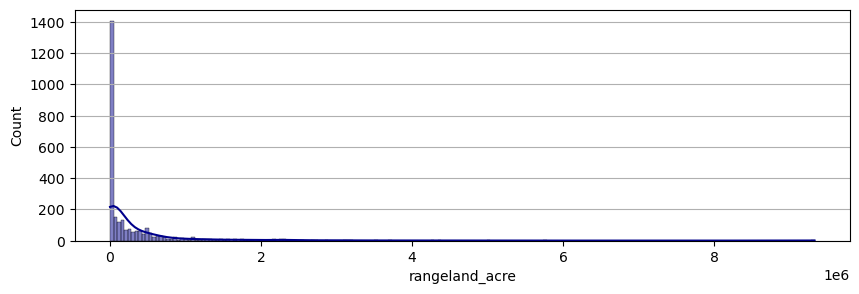

In [94]:
fig, axes = plt.subplots(1, 1, figsize=(10, 3), sharey=False, sharex=False)
axes.grid(axis='y', which='both');
sns.histplot(data=cnty_ann_SW_NPP_Ra.rangeland_acre, kde=True, bins=200, color = 'darkblue', ax=axes);

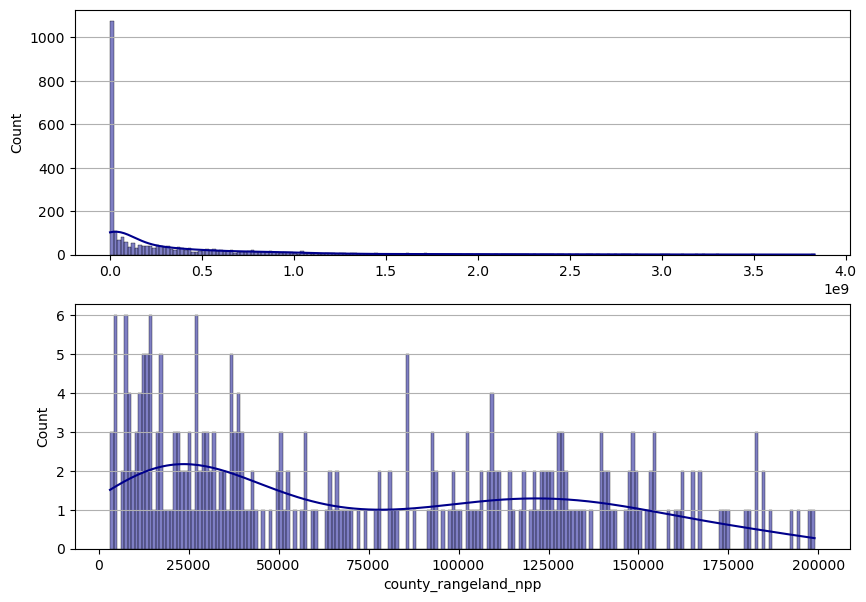

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(10, 7), sharey=False, sharex=False)
(ax1, ax2) = axes;
ax1.grid(axis='y', which='both'); ax2.grid(axis='y', which='both')

sns.histplot(data=cnty_ann_SW_NPP_Ra.county_rangeland_npp, kde=True, bins=200, color = 'darkblue', ax=ax1);

A = cnty_ann_SW_NPP_Ra[cnty_ann_SW_NPP_Ra.county_rangeland_npp < 200000]
sns.histplot(data=A.county_rangeland_npp, kde=True, bins=200, color = 'darkblue', ax=ax2);

ax1.set_xlabel("");

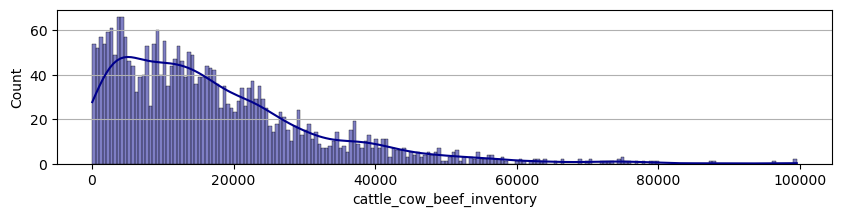

In [96]:
fig, axes = plt.subplots(1, 1, figsize=(10, 2), sharey=False, sharex=False)
axes.grid(axis='y', which='both'); ax2.grid(axis='y', which='both')
sns.histplot(data=cnty_ann_SW_NPP_Ra[inv_col_], kde=True, bins=200, color = 'darkblue', ax=axes);

In [97]:
tick_legend_FontSize = 8

params = {'legend.fontsize': tick_legend_FontSize, # medium, large
          # 'figure.figsize': (6, 4),
          'axes.labelsize': tick_legend_FontSize*1.5,
          'axes.titlesize': tick_legend_FontSize*1.3,
          'xtick.labelsize': tick_legend_FontSize*1.1, #  * 0.75
          'ytick.labelsize': tick_legend_FontSize*1.1, #  * 0.75
          'axes.titlepad': 10}

plt.rc('font', family = 'Palatino')
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['ytick.labelleft'] = True
plt.rcParams.update(params)

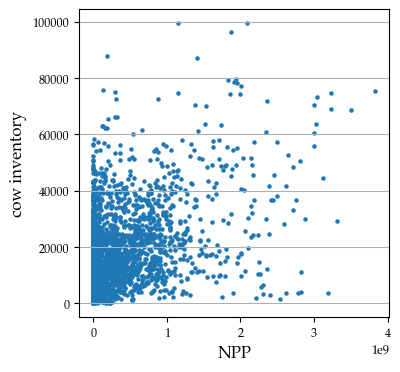

In [98]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
axes.grid(axis='y', which='both');
axes.scatter(cnty_ann_SW_NPP_Ra.county_rangeland_npp, cnty_ann_SW_NPP_Ra[inv_col_], s = 5)

axes.set_xlabel("NPP");
axes.set_ylabel("cow inventory");
plt.show()

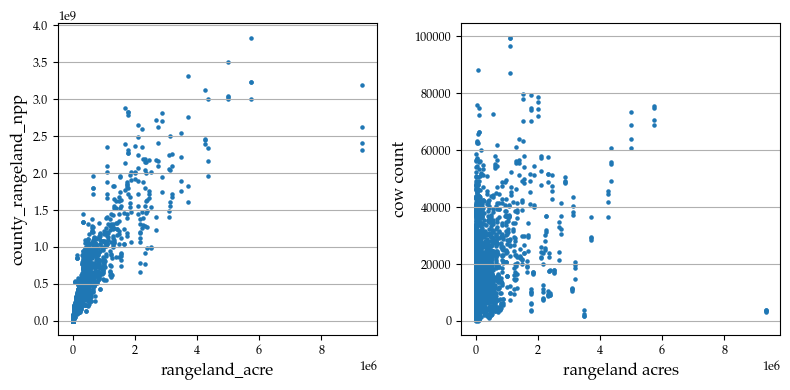

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
(ax1, ax2) = axes;
ax1.grid(axis='y', which='both'); 
ax2.grid(axis='y', which='both');
#############
ax1.scatter(cnty_ann_SW_NPP_Ra.rangeland_acre, cnty_ann_SW_NPP_Ra.county_rangeland_npp, s = 5)
ax1.set_xlabel("rangeland_acre");
ax1.set_ylabel("county_rangeland_npp");
#############
ax2.scatter(cnty_ann_SW_NPP_Ra.rangeland_acre, cnty_ann_SW_NPP_Ra.cattle_cow_beef_inventory, s = 5)
ax2.set_xlabel("rangeland acres");
ax2.set_ylabel("cow count");
#############
fig.tight_layout()
plt.show()

In [100]:
# NPP = pd.read_csv(Min_data_base + "county_annual_MODIS_NPP.csv")
# RA = pd.read_csv(reOrganized_dir + "county_rangeland_and_totalarea_fraction.csv")
# RA.rename(columns={"fips_id": "county_fips"}, inplace=True)
# NPP.rename(columns={"county": "county_fips"}, inplace=True)
# NPP_RA = pd.merge(NPP, RA, on=["county_fips"], how="left")
# fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
# axes.grid(axis='y', which='both');
# axes.scatter(NPP_RA.rangeland_acre, NPP_RA.NPP, s = 5)
# axes.set_xlabel("Acres");
# axes.set_ylabel("NPP");
# plt.show()

In [101]:
cnty_ann_SW_NPP_Ra.head(2)

,year,county_fips,county_rangeland_npp,rangeland_acre,county_area_acre,rangeland_fraction,cattle_cow_beef_inventory,S1_countyMean_total_precip,S2_countyMean_total_precip,S3_countyMean_total_precip,S4_countyMean_total_precip,S1_countyMean_avg_Tavg,S2_countyMean_avg_Tavg,S3_countyMean_avg_Tavg,S4_countyMean_avg_Tavg,herb_avg,herb_std,pixel_count,modis_npp
0,2002,01055,130631.174115,57.60,352368.00,0.000163,12020.0,384.081,381.902,297.505,444.936,8.504456,22.419525,25.522639,11.011326,29.333333,32.293790,3.0,0.560410
1,2002,01129,206902.523895,95.62,697429.12,0.000137,5364.0,363.117,419.090,391.772,572.797,11.222078,24.012369,26.272246,14.197446,13.133851,15.783407,1158.0,0.534686


# Residual Plots

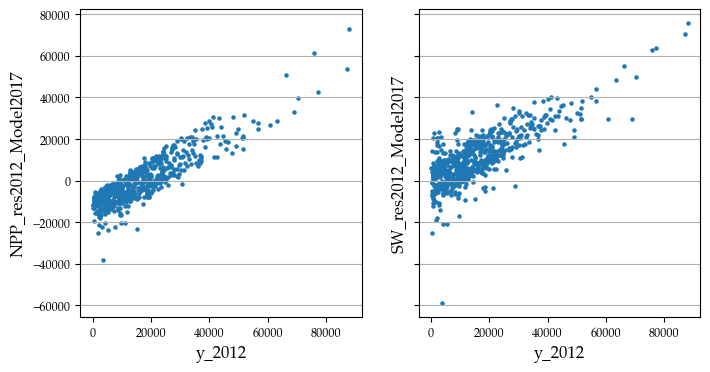

In [102]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
(ax1, ax2) = axes;
ax1.grid(axis='y', which='both'); ax2.grid(axis='y', which='both');
##################################################
ax1.scatter(y_2012, NPP_res2012_Model2017, s = 5)
ax1.set_xlabel("y_2012");
ax1.set_ylabel("NPP_res2012_Model2017");
##################################################
ax2.scatter(y_2012, SW_res2012_Model2017, s = 5)
ax2.set_xlabel("y_2012");
ax2.set_ylabel("SW_res2012_Model2017");
plt.show()

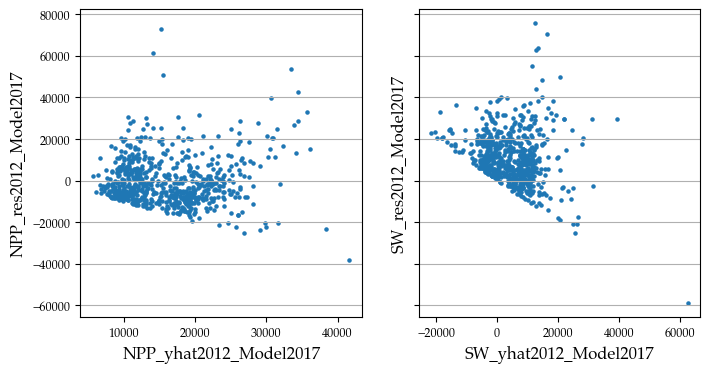

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
(ax1, ax2) = axes;
ax1.grid(axis='y', which='both'); 
ax2.grid(axis='y', which='both');
##################################################
ax1.scatter(NPP_yhat2012_Model2017, NPP_res2012_Model2017, s = 5)
ax1.set_xlabel("NPP_yhat2012_Model2017");
ax1.set_ylabel("NPP_res2012_Model2017");
##################################################
ax2.scatter(SW_yhat2012_Model2017, SW_res2012_Model2017, s = 5)
ax2.set_xlabel("SW_yhat2012_Model2017");
ax2.set_ylabel("SW_res2012_Model2017");
plt.show()

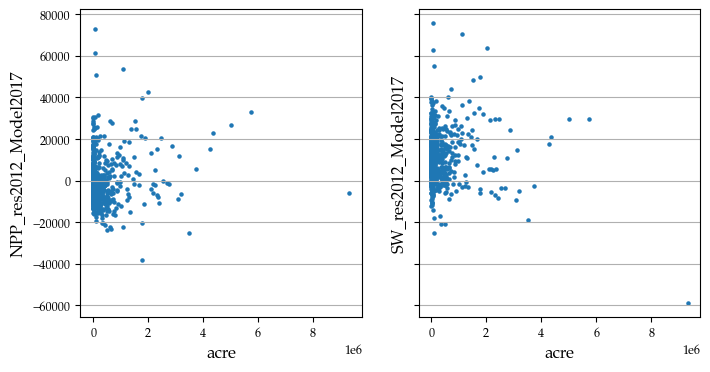

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
(ax1, ax2) = axes;
ax1.grid(axis='y', which='both'); 
ax2.grid(axis='y', which='both');
##################################################
ax1.scatter(SW_Ra_cattleInv_2012.rangeland_acre, NPP_res2012_Model2017, s = 5)
ax1.set_xlabel("acre");
ax1.set_ylabel("NPP_res2012_Model2017");
##################################################
ax2.scatter(NPP_Ra_cattleInv_2012.rangeland_acre, SW_res2012_Model2017, s = 5)
ax2.set_xlabel("acre");
ax2.set_ylabel("SW_res2012_Model2017");
##################################################
plt.show()

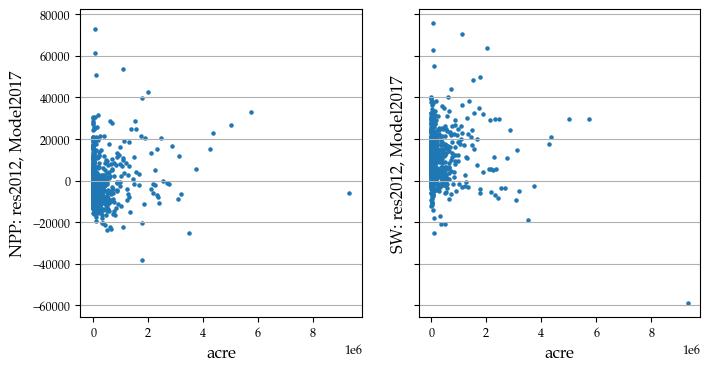

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
(ax1, ax2) = axes;
ax1.grid(axis='y', which='both'); 
ax2.grid(axis='y', which='both');
##################################################
ax1.scatter(SW_Ra_cattleInv_2012.rangeland_acre, NPP_res2012_Model2017, s = 5)
ax1.set_xlabel("acre");
ax1.set_ylabel("NPP: res2012, Model2017");
##################################################
ax2.scatter(NPP_Ra_cattleInv_2012.rangeland_acre, SW_res2012_Model2017, s = 5)
ax2.set_xlabel("acre");
ax2.set_ylabel("SW: res2012, Model2017");
plt.show()

## Model with ```log```

#### Plot logs first.

In [106]:
# ax1.set_title(r'$d_n$')
# ax1.set_title('2nd root');
# ax2.set_title('log10');
# ax3.set_title('log10');

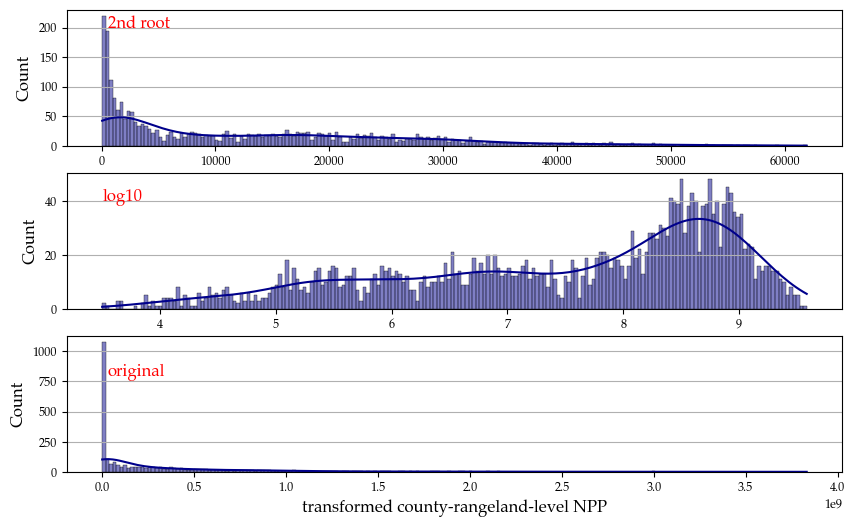

In [141]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=False, sharex=False)
(ax1, ax2, ax3) = axes;
ax1.grid(axis='y', which='both'); ax2.grid(axis='y', which='both'); ax3.grid(axis='y', which='both');

text_size, text_color = "large", "r"

data_ = cnty_ann_SW_NPP_Ra.county_rangeland_npp
sns.histplot(data = np.sqrt(data_), kde = True, bins=200, color = 'darkblue', ax=ax1);
ax1.text(x=np.sqrt(data_).min()+500, y=200, s='2nd root', fontsize=text_size, color=text_color)
###########################################
sns.histplot(data = np.log10(data_) , kde = True, bins=200, color = 'darkblue', ax=ax2);
ax2.text(x = np.log10(data_).min(), y=40, s='log10', fontsize=text_size, color=text_color)
###########################################
# sns.histplot(data = 1/data_, kde = True, bins=200, color = 'darkblue', ax=ax3);
# ax3.text(x = (1/data_).min(), y=2000, s='inverse', fontsize=text_size, color=text_color)
sns.histplot(data = data_, kde = True, bins=200, color = 'darkblue', ax=ax3);
ax3.text(x = data_.min()+30000000, y=800, s='original', fontsize=text_size, color=text_color)


ax1.set_xlabel(""); ax2.set_xlabel(""); ax3.set_xlabel("transformed county-rangeland-level NPP");


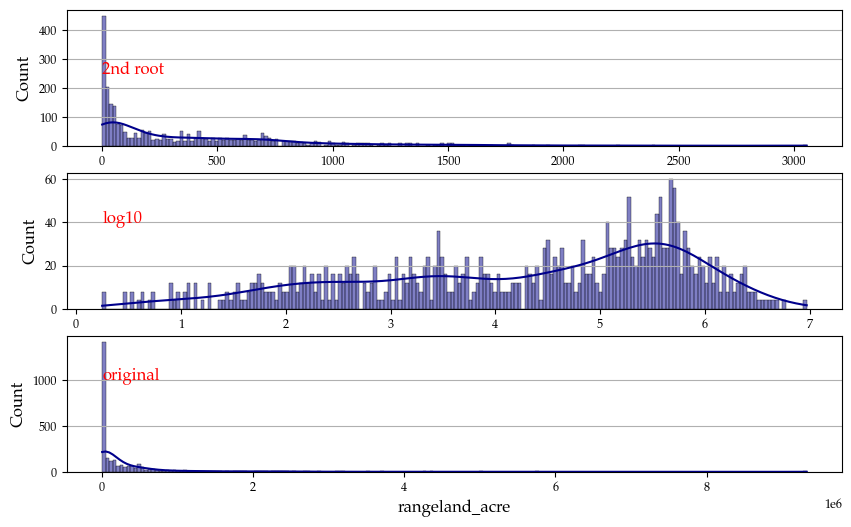

In [128]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=False, sharex=False)
(ax1, ax2, ax3) = axes;
ax1.grid(axis='y', which='both'); ax2.grid(axis='y', which='both'); ax3.grid(axis='y', which='both');

text_size, text_color = "large", "r"

data_ = cnty_ann_SW_NPP_Ra.rangeland_acre
sns.histplot(data = np.sqrt(data_), kde = True, bins=200, color = 'darkblue', ax=ax1);
ax1.text(x=np.sqrt(data_).min(), y=250, s='2nd root', fontsize=text_size, color=text_color)
###########################################
sns.histplot(data = np.log10(data_) , kde = True, bins=200, color = 'darkblue', ax=ax2);
ax2.text(x = np.log10(data_).min(), y=40, s='log10', fontsize=text_size, color=text_color);
###########################################
sns.histplot(data = data_ , kde = True, bins=200, color = 'darkblue', ax=ax3);
ax3.text(x = data_.min()+1, y=1000, s='original', fontsize=text_size, color=text_color);


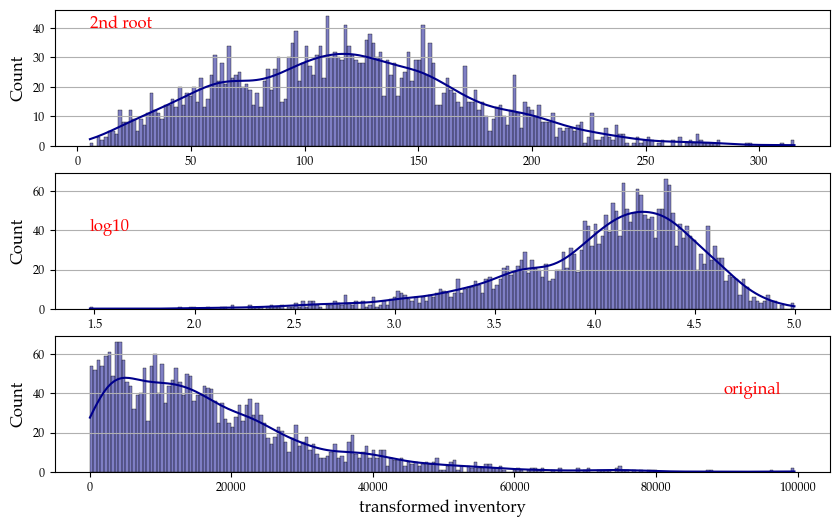

In [124]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=False, sharex=False)
(ax1, ax2, ax3) = axes;
ax1.grid(axis='y', which='both'); ax2.grid(axis='y', which='both'); ax3.grid(axis='y', which='both');

text_size, text_color = "large", "r"

data_ = cnty_ann_SW_NPP_Ra[inv_col_]

sns.histplot(data=np.sqrt(data_), kde = True, bins=200, color = 'darkblue', ax=ax1);
ax1.text(x = np.sqrt(data_).min(), y = 40, s='2nd root', fontsize = text_size, color = text_color)
###########################################

sns.histplot(data=np.log10(data_) , kde = True, bins=200, color = 'darkblue', ax=ax2);
ax2.text(x=np.log10(data_).min(), y=40, s='log10', fontsize=text_size, color=text_color)
###########################################
sns.histplot(data=data_, kde = True, bins=200, color = 'darkblue', ax=ax3);
ax3.text(x=data_.max()-10000, y=40, s='original', fontsize=text_size, color=text_color);

ax1.set_xlabel(""); ax2.set_xlabel(""); ax3.set_xlabel("transformed inventory");


/Users/hn/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/hn/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


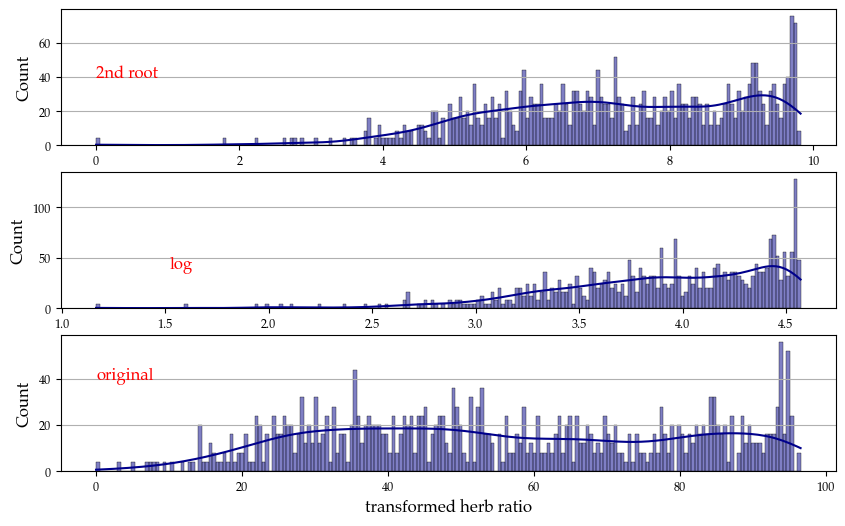

In [156]:
fig, axes = plt.subplots(3, 1, figsize=(10, 6), sharey=False, sharex=False)
(ax1, ax2, ax3) = axes;
ax1.grid(axis='y', which='both'); ax2.grid(axis='y', which='both'); ax3.grid(axis='y', which='both');

text_size, text_color = "large", "r"

herb_col = "herb_avg"
data_ = cnty_ann_SW_NPP_Ra[herb_col]

sns.histplot(data=np.sqrt(data_), kde = True, bins=200, color = 'darkblue', ax=ax1);
ax1.text(x = np.sqrt(data_).min(), y = 40, s='2nd root', fontsize = text_size, color = text_color)
###########################################

sns.histplot(data=np.log(data_), kde = True, bins=200, color = 'darkblue', ax=ax2);
ax2.text(x=np.log(data_).max()/3, y=40, s='log', fontsize=text_size, color=text_color)

# ###########################################
sns.histplot(data=data_, kde = True, bins=200, color = 'darkblue', ax=ax3);
ax3.text(x=data_.min(), y=40, s='original', fontsize=text_size, color=text_color);

ax1.set_xlabel(""); ax2.set_xlabel(""); ax3.set_xlabel("transformed herb ratio");


## OLS w/ 2nd root of inventory and log of NPP, and log of rangeland acre

In [157]:
county_annual_NPP_Ra_cattleInv.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count
0,2002,01055,57.60,352368.00,0.000163,130631.174115,12020.0,29.333333,32.293790,3.0
1,2002,01129,95.62,697429.12,0.000137,206902.523895,5364.0,13.133851,15.783407,1158.0


In [158]:
county_annual_NPP_Ra_cattleInv["sqrt_cattle_cow_beef_inventory"] = \
              np.sqrt(county_annual_NPP_Ra_cattleInv["cattle_cow_beef_inventory"])
    
county_annual_NPP_Ra_cattleInv["log_county_rangeland_npp"] = \
                             np.log10(county_annual_NPP_Ra_cattleInv["county_rangeland_npp"])
    
county_annual_NPP_Ra_cattleInv["log_rangeland_acre"] = np.log10(county_annual_NPP_Ra_cattleInv["rangeland_acre"])

In [159]:
NPP_Ra_cattleInv_2017 = county_annual_NPP_Ra_cattleInv[
                                        county_annual_NPP_Ra_cattleInv.year==2017].copy()
# NPP_Ra_cattleInv_2017 = NPP_Ra_cattleInv_2017.round(decimals=2)
NPP_Ra_cattleInv_2017.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count,sqrt_cattle_cow_beef_inventory,log_county_rangeland_npp,log_rangeland_acre
2031,2017,01055,57.60,352368.00,0.000163,205588.913435,8872.0,29.333333,32.293790,3.0,94.191295,5.313000,1.760422
2032,2017,01129,95.62,697429.12,0.000137,338831.349761,6884.0,13.133851,15.783407,1158.0,82.969874,5.529984,1.980549


In [160]:
inv_col_ = "sqrt_cattle_cow_beef_inventory"

In [161]:
NPP_Ra_cattleInv_2017.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count,sqrt_cattle_cow_beef_inventory,log_county_rangeland_npp,log_rangeland_acre
2031,2017,01055,57.60,352368.00,0.000163,205588.913435,8872.0,29.333333,32.293790,3.0,94.191295,5.313000,1.760422
2032,2017,01129,95.62,697429.12,0.000137,338831.349761,6884.0,13.133851,15.783407,1158.0,82.969874,5.529984,1.980549


In [162]:
NPP_A_2017 = NPP_Ra_cattleInv_2017[["county_rangeland_npp", "log_rangeland_acre", "herb_avg"]].values
NPP_A_2017 = np.hstack([NPP_A_2017, np.ones(len(NPP_A_2017)).reshape(-1, 1)])
print (NPP_A_2017.shape)

y_2017 = NPP_Ra_cattleInv_2017[[inv_col_]].values.reshape(-1)
print (f"{y_2017.shape = }")

(677, 4)
y_2017.shape = (677,)


In [163]:
NPP_sol_2017, NPP_RSS_2017, NPP_rank_2017, NPP_singular_vals_2017  = np.linalg.lstsq(NPP_A_2017, y_2017)
NPP_sol_2017

array([ 3.63010586e-08, -6.48542882e+00,  9.24617542e-01,  8.15652234e+01])

In [164]:
NPP_Ra_cattleInv_2012 = county_annual_NPP_Ra_cattleInv[
                                        county_annual_NPP_Ra_cattleInv.year==2012].copy()

y_2012 = NPP_Ra_cattleInv_2012[[inv_col_]].values.reshape(-1)

In [165]:
NPP_Ra_cattleInv_2012.head(2)

,year,county_fips,rangeland_acre,county_area_acre,rangeland_fraction,county_rangeland_npp,cattle_cow_beef_inventory,herb_avg,herb_std,pixel_count,sqrt_cattle_cow_beef_inventory,log_county_rangeland_npp,log_rangeland_acre
1354,2012,01055,57.60,352368.00,0.000163,164943.388247,10647.0,29.333333,32.293790,3.0,103.184301,5.217335,1.760422
1355,2012,01129,95.62,697429.12,0.000137,266392.249292,4815.0,13.133851,15.783407,1158.0,69.390201,5.425522,1.980549


In [166]:
NPP_A_2012 = NPP_Ra_cattleInv_2012[["log_county_rangeland_npp", "log_rangeland_acre", "herb_avg"]].copy()
NPP_A_2012 = NPP_A_2012.values

NPP_A_2012 = np.hstack([NPP_A_2012, np.ones(len(NPP_A_2012)).reshape(-1, 1)])

NPP_logyhat2012_Model2017 = NPP_A_2012 @ NPP_sol_2017

In [167]:
## inverse of log10 to get actual prediction (as opposed to log of predictions)
NPP_yhat2012_Model2017 = (NPP_logyhat2012_Model2017)**2

In [168]:
NPP_res2012_transModel2017 = y_2012 - NPP_yhat2012_Model2017
NPP_RSS2012_transModel2017 = np.dot(NPP_res2012_transModel2017, NPP_res2012_transModel2017)

### unit ```NPP``` results were:

- $\text{RSS}_\text{unit-NPP} = 107,997,845,546$
- $\text{MSE}_\text{unit-NPP} = 155,392,584$
- $\text{RSE}_\text{unit-NPP} = 12,466$

In [169]:
print ("NPP residual stats:")
print('    RSS = {0:.0f}.'.format(NPP_RSS2012_Model2017))
print('    MSE = {0:.0f}.'.format(NPP_RSS2012_Model2017/len(y_2012)))
print('    RSE = {0:.0f}.'.format(np.sqrt(NPP_RSS2012_Model2017/len(y_2012))))
print ()
print ("NPP residual stats for transformed model:")
print('    RSS = {0:.0f}.'.format(NPP_RSS2012_transModel2017))
print('    MSE = {0:.0f}.'.format(NPP_RSS2012_transModel2017/len(y_2012)))
print('    RSE = {0:.0f}.'.format(np.sqrt(NPP_RSS2012_transModel2017/len(y_2012))))

NPP residual stats:
    RSS = 88678641356.
    MSE = 130987653.
    RSE = 11445.

NPP residual stats for transformed model:
    RSS = 96261587730.
    MSE = 142188460.
    RSE = 11924.
